# Frequency-Domain BSS



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from scipy.signal import stft, istft
from scipy.io import wavfile
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
BASE_PATH = '/content/drive/My Drive/blind_source_separation/'
MODULE_DIR = os.path.join(BASE_PATH,'modules')
sys.path.append(BASE_PATH)
sys.path.append(MODULE_DIR)
os.listdir(MODULE_DIR)

['__pycache__',
 'separation.py',
 'permutation.py',
 'auxiliaries.py',
 'clustering.py',
 'tf_masking.py']

In [4]:
from auxiliaries import *
from separation import *
from permutation import *
from clustering import *
from tf_masking import *

# Load Wave Files

https://cnl.salk.edu/~tewon/Blind/blind_audio.html

In [5]:
from IPython.display import Audio
Audio(os.path.join(BASE_PATH,'data/mixed/rss_mA.wav'))

In [6]:
Audio(os.path.join(BASE_PATH,'data/mixed/rss_mB.wav'))

In [7]:
fs, waveA = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mA.wav'))
_, waveB = wavfile.read(os.path.join(BASE_PATH,'data/mixed/rss_mB.wav'))

Xt = np.vstack([waveA,waveB])

print_characteristics([waveA, waveB, fs, Xt])

type:	<class 'numpy.ndarray'>
shape:	(119000,)
dtype:	int16

type:	<class 'numpy.ndarray'>
shape:	(119000,)
dtype:	int16

type:	<class 'int'>

type:	<class 'numpy.ndarray'>
shape:	(2, 119000)
dtype:	int16



# Blind Source Separation
## STFT

In [8]:
nperseg=1000
f,t,Xfn = stft(Xt,fs,nperseg=nperseg)

print_characteristics([t,f,Xfn,Xt])

type:	<class 'numpy.ndarray'>
shape:	(239,)
dtype:	float64

type:	<class 'numpy.ndarray'>
shape:	(501,)
dtype:	float64

type:	<class 'numpy.ndarray'>
shape:	(2, 501, 239)
dtype:	complex64

type:	<class 'numpy.ndarray'>
shape:	(2, 119000)
dtype:	int16



## Separation

In [9]:
@timit
def source_separation_test(Xfn, f, max_iter=1000):
    Yfn = np.zeros_like(Xfn)
    Wf = np.zeros((Xfn.shape[1],Xfn.shape[0],Xfn.shape[0]),dtype=np.complex128) 
    for i in trange(Xfn.shape[1], desc='1st loop'):
        Xn = Xfn[:,i,:]
        
        V, Z = whitening(Xn)
        U, _ = complex_FastICA(Z, max_iter=max_iter, history=False)
        W, Y = MLE(Xn, V, U, max_iter=max_iter, step_size=1e-5, tol=1e-7, history=False)
        
        Yfn[:,i,:] = Y
        Wf[i,:,:] = W
    return Wf, Yfn

In [10]:
TRAIN=False
max_iter=10000

if TRAIN:
  Wf,Yfn = source_separation(Xfn,f,max_iter=max_iter)
  np.save(os.path.join(BASE_PATH,'output/Wf_itr={}_rss_mA.npy'.format(max_iter)),Wf)
  np.save(os.path.join(BASE_PATH,'output/Yf_itr={}_rss_mA.npy'.format(max_iter)),Yfn)
else:
  Yfn=np.load(os.path.join(BASE_PATH,'output/Yf_itr={}_rss_mA.npy'.format(max_iter)))
  Wf=np.load(os.path.join(BASE_PATH,'output/Wf_itr={}_rss_mA.npy'.format(max_iter)))

print_characteristics([Wf,Yfn])

type:	<class 'numpy.ndarray'>
shape:	(501, 2, 2)
dtype:	complex128

type:	<class 'numpy.ndarray'>
shape:	(2, 501, 239)
dtype:	complex64



Restrict frequency space

In [11]:
lower_f_bound = 1
Yf_ = [[Yfn[:,i,:],f[i]] for i in range(lower_f_bound,len(f))]
Wf_ = [[Wf[i,:,:],f[i]] for i in range(lower_f_bound,len(f))]

## Permutation

In [12]:
rf_est = TDOA_estimator(Wf_)
perms, _ = cluster(rf_est)
WfP_,YfP_ = perm_alignment(rf_est, Wf_, Yf_, perms)

print_characteristics([rf_est,perms,WfP_,YfP_])

Converged at itr=1
type:	<class 'numpy.ndarray'>
shape:	(500, 2)
dtype:	float64

type:	<class 'numpy.ndarray'>
shape:	(500, 2)
dtype:	int64

type:	<class 'numpy.ndarray'>
shape:	(500, 2)
dtype:	object

type:	<class 'numpy.ndarray'>
shape:	(500, 2)
dtype:	object



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Scaling

In [13]:
YfS_ = scale(WfP_,YfP_)

print_characteristics(YfS_)

type:	<class 'numpy.ndarray'>
shape:	(500, 2)
dtype:	object



/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## T-F Masking

In [14]:
theta_max = 0.5
YfnM = mask(Xfn,YfS_,WfP_,theta_max=0.4)

print_characteristics(YfnM)

/content/drive/My Drive/blind_source_separation/modules/tf_masking.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.arccos(phi.astype(np.float64))


type:	<class 'numpy.ndarray'>
shape:	(2, 500, 239)
dtype:	complex128



## Inverse STFT

In [15]:
print(Xfn[:,:lower_f_bound,:].shape)
print(YfnM.shape)
Yfn_f=np.concatenate((Xfn[:,:lower_f_bound,:],YfnM),axis=1)

print_characteristics(Yfn_f)

(2, 1, 239)
(2, 500, 239)
type:	<class 'numpy.ndarray'>
shape:	(2, 501, 239)
dtype:	complex128



In [16]:
print(fs)
tt, Yt = istft(Yfn_f,fs)

16000


In [17]:
wavfile.write(os.path.join(BASE_PATH,'data/separated/source_1_itr={}.wav'.format(max_iter)), fs, Yt[0].astype(np.int16))
wavfile.write(os.path.join(BASE_PATH,'data/separated/source_2_itr={}.wav'.format(max_iter)), fs, Yt[1].astype(np.int16))

In [18]:
Audio(Yt[0],rate=fs,autoplay=False)

In [19]:
Audio(Yt[1],rate=fs,autoplay=False)

# Analysis

## Influence Missing Frequency Slice

### Remove Slice

In [20]:
fA,tA,XfnA=stft(Xt,fs,nperseg=nperseg)
ttA,XXtA=istft(XfnA[:,lower_f_bound:,:],fs)

In [21]:
Audio(Xt[0],rate=fs,autoplay=False)

In [22]:
Audio(XXtA[0],rate=fs)

### Add Zeros versus Add Mixed Signal

In [23]:
bottom = np.zeros_like(Xfn[:,:lower_f_bound,:])
ZfnA=np.concatenate((bottom,YfnM),axis=1)
print(XfnA.shape)
print(ZfnA.shape)
ttA, ZtA = istft(ZfnA,fs)

(2, 501, 239)
(2, 501, 239)


In [24]:
Audio(ZtA[0],rate=fs,autoplay=False)

In [25]:
ZXfnA=np.concatenate((Xfn[:,:lower_f_bound,:],YfnM),axis=1)

ttA, ZXtA = istft(ZXfnA,fs)

In [26]:
Audio(ZXtA[0],rate=fs,autoplay=False)

### Check Concatenate Order

In [27]:
theta_max=.4

YfnO = mask(Xfn,YfS_,WfP_,theta_max=theta_max)
YfnO=np.concatenate((YfnO,Xfn[:,:lower_f_bound,:]),axis=1)
tt, YtO = istft(YfnO,fs)
OfnY=np.concatenate((Xfn[:,:lower_f_bound,:],YfnO),axis=1)
tt, OtY = istft(OfnY,fs)

/content/drive/My Drive/blind_source_separation/modules/tf_masking.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.arccos(phi.astype(np.float64))


In [28]:
Audio(YtO[1],rate=fs,autoplay=False)

In [29]:
Audio(OtY[1],rate=fs)

## Masking Tradeoff

In [30]:
theta_max=[0.1*i for i in range(1, 21)]

Y_theta=[]

for val in theta_max:
  YT = mask(Xfn,YfS_,WfP_,theta_max=val)
  YT=np.concatenate((Xfn[:,:lower_f_bound,:],YT),axis=1)
  ttA, YtT = istft(YT,fs)
  Y_theta.append(YtT)

/content/drive/My Drive/blind_source_separation/modules/tf_masking.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.arccos(phi.astype(np.float64))


/content/drive/My Drive/blind_source_separation/modules/tf_masking.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.arccos(phi.astype(np.float64))



Theta_max = 0.80
Filling mask 0:	50.00%
Filling mask 1:	51.98%
Source:	0


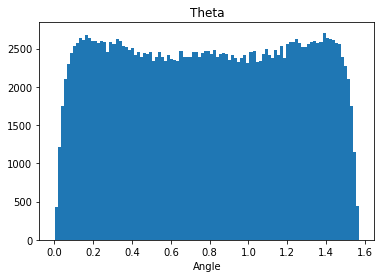

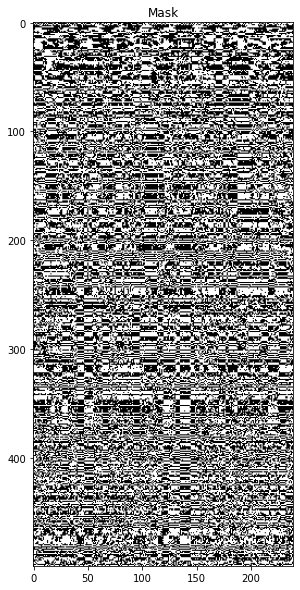

In [31]:
f=0.8

source = 0
idx=int(f/0.1)-1

Xf_ = [Xfn[:,i,:] for i in range(1, Xfn.shape[1])]
theta = get_theta(Xf_,Wf_)
theta = np.swapaxes(theta,0,1)

plt.hist(theta.flatten(),100)
plt.title("Theta")
plt.xlabel('Angle')
M = np.where(theta<theta_max[idx],1,0)
print()
print('Theta_max = {:.2f}'.format(theta_max[idx]))
print('Filling mask 0:\t{:.2f}%'.format(M[0].sum()/1195))
print('Filling mask 1:\t{:.2f}%'.format(M[1].sum()/1195))
print('Source:\t'+str(source))
plt.figure(figsize=(10,10));
plt.title('Mask')
plt.imshow(M[source], cmap=plt.cm.gray);

In [32]:
print('Theta_max = {:.2f}'.format(theta_max[idx]))
print()
Audio(Y_theta[idx][0],rate=fs,autoplay=False)

Theta_max = 0.80



In [33]:
Audio(Y_theta[idx][1],rate=fs,autoplay=False)

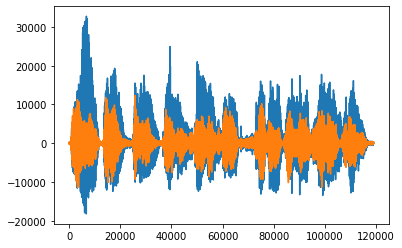

In [34]:
plt.plot(Xt[source])
plt.plot(Y_theta[idx][source])
plt.show()

Converged at itr=1
(500, 2)


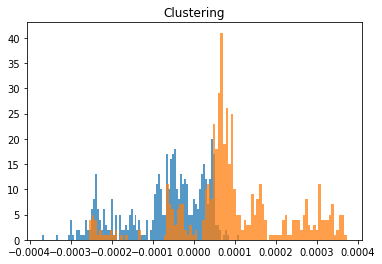

In [35]:
perms,_=cluster(rf_est)
P=get_permutation_matrix(perms)
r_perm_est=np.asarray(list(map(np.dot,P, rf_est)))
rf_clean=r_perm_est[abs(r_perm_est).max(1)<4e-4]

print(r_perm_est.shape)

plt.hist(rf_clean[:,0],bins=100,alpha=.75)
plt.hist(rf_clean[:,1],bins=100,alpha=.75)
plt.title('Clustering')
plt.show()